# Imports

In [1]:
import scanpy as sc
import pandas as pd
import torch
import numpy

import fiberedae.models.fae as vmod
import fiberedae.utils.basic_trainer as vtrain
import fiberedae.utils.persistence as vpers
import fiberedae.utils.single_cell as vsc
import fiberedae.utils.nn as vnnutils
import fiberedae.utils.plots as vplots
import fiberedae.utils.fae as vfae
import fiberedae.utils.datasets as vdatasets

from anndata import AnnData

import fiberedae.utils.useful as us

/home/tariq/miniconda3/envs/fae/lib/python3.7/site-packages/anndata-0.7.1-py3.7.egg/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Kang INF Beta stimulated cells
This dataset contains batches of stimulated and stimualated PBMCs.

## Loading dataset and configuration

In [2]:
train_hv = sc.read("./datasets/kang_normalized_2khv.h5ad", backup_url="https://www.dropbox.com/s/8jq33luekpdnytt/kang_normalized_2khv.h5ad?dl=1)

## Original uncorrected dataset

## Training and saving model
In this section we train the model on the full gene expression matrix

## Loading model and configuration

In [4]:
train_hv.X = train_hv.X - numpy.min(train_hv.X)
train_hv.X = train_hv.X / numpy.max(train_hv.X)

In [9]:
sc.pp.pca(train_hv)
sc.pp.neighbors(train_hv)
sc.tl.umap(train_hv)

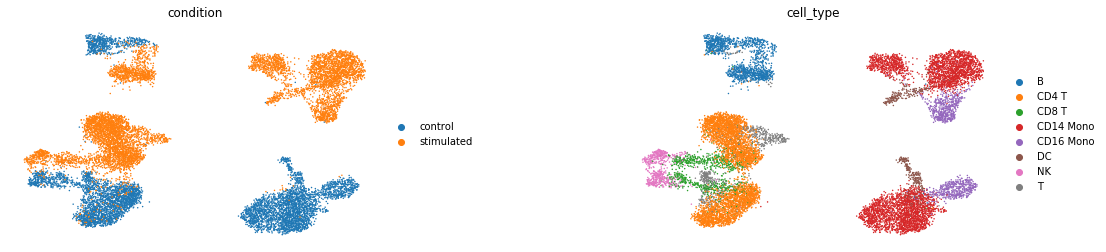

In [10]:
sc.pl.umap(train_hv, color=["condition", "cell_type"], wspace=.5, frameon=False)

In [5]:
config = us.load_configuration("configurations/kang_pbmc.json")
dataset = vdatasets.make_single_cell_dataset(
    batch_size=config["hps"]["minibatch_size"],
    condition_field=config["dataset"]["condition_field"],
    adata=train_hv,
    dataset_name=config["dataset"]["name"],
    oversample=True
)

condition [control, stimulated]
Categories (2, object): [control, stimulated]
range of sample inputs: (tensor(1.), tensor(0.))


In [6]:
config

{'dataset': {'name': 'single_cell',
  'condition_field': 'condition',
  'dataset_name': 'kang pbmc'},
 'trainer': {'l_contraction': 0},
 'model': {'h_dim': 256,
  'non_linearity': <function _VariableFunctions.sin>,
  'nb_hidden': 20,
  'gan_discriminator_h_dim': 256,
  'gan_discriminator_nb_hidden': 3,
  'gan_discriminator_non_linearity': LeakyReLU(negative_slope=0.01),
  'conditioned': True,
  'projection_type': 'cube',
  'wgan': True,
  'base_dim': 1,
  'fiber_dim': 16,
  'nb_fiber_hidden': 2,
  'fiber_batchnorm': False,
  'condition_adv_h_dim': 256,
  'condition_adv_nb_hidden': 3,
  'condition_adv_non_linearity': ReLU(),
  'condition_fit_h_dim': 256,
  'condition_fit_nb_hidden': 3,
  'condition_fit_non_linearity': LeakyReLU(negative_slope=0.01),
  'residual_fiber': True,
  'residual_base': True,
  'contract_fiber': False,
  'contract_base': False},
 'optimizers': {'reconstruction': <function fiberedae.utils.useful.get_optimizer.<locals>._do(params)>,
  'gan_generator': <function fib

In [7]:
model_args = dict(config["model"])
model_args.update(
    dict(
        x_dim=dataset["shapes"]["input_size"],
        nb_class=dataset["shapes"]["nb_class"],
        output_transform=vnnutils.ScaleNonLinearity(-1., 1., dataset["sample_scale"][0], dataset["sample_scale"][1]),
    )
)
#make model
model = vmod.FiberedAE(**model_args)
model.to("cuda")

#train model
trainer, history = us.train(model, dataset, config, nb_epochs=config["hps"]["nb_epochs"])

  0%|          | 0/2000 [00:00<?, ?it/s]

running on: cuda


re: 0.0000,coad: 0.6773,pr: 0.3150,cofige: 0.3150,gadi: -0.1969,gage: 0.1154: 100%|██████████| 2000/2000 [2:17:30<00:00,  4.10s/it]  


In [7]:
vpers.save_model(model, {}, history, {}, dataset["label_encoding"], model_args,
                 "./trained_models/%s_%se.pytorch.mdl" % (
                     config["dataset"]["dataset_name"].replace(" ", "_"),
                     config["hps"]["nb_epochs"]
                 )
                )

In [4]:
#model = vpers.load_model("./trained_models/kang_pbmc_16_hv_2000e.pytorch.mdl", vmod.FiberedAE, "cpu")[0]

## Learning curves

In [ ]:
vplots.interactive_line_plots(
    dct_values = {
        "G": history["train"]["gan_discriminator"],
        "GD": history["train"]["gan_generator"]
    },
    x_label = "epochs",
    y_label = "loss",
)

## Latent space plots

In [16]:
latent_space = vfae.get_latent_space(
    model=model,
    data_loader=dataset["loaders"]["train"],
    batch_formater=dataset["batch_formater"],
    label_encoding=dataset["label_encoding"]
)

In [ ]:
vplots.plot_latent(latent_space["base_space"], latent_space["str_labels"], point_opacity=1 )

In [ ]:
vplots.plot_latent(latent_space["fiber_space"], latent_space["str_labels"])

## Batch correction
Here we correct the batch effect by using the model to translate all gene expressions into the domain of a single reference batch. In all subesquent figures we see that, post-translation cells from different batches are well mixed and that cell now cluster by cell types instead of batch. Here it is important to note that the model had no explicit knowledge of cell types during training.

## Taking control as reference

In [8]:
adjusted_adata = vsc.translate(model, train_hv, "condition", 'control', dataset["label_encoding"], batch_size=1024)

In [24]:
adjusted_adata.write("./fae_naive_16_ctrl.h5ad")

In [9]:
sc.pp.pca(adjusted_adata)
sc.pp.neighbors(adjusted_adata)
sc.tl.umap(adjusted_adata)

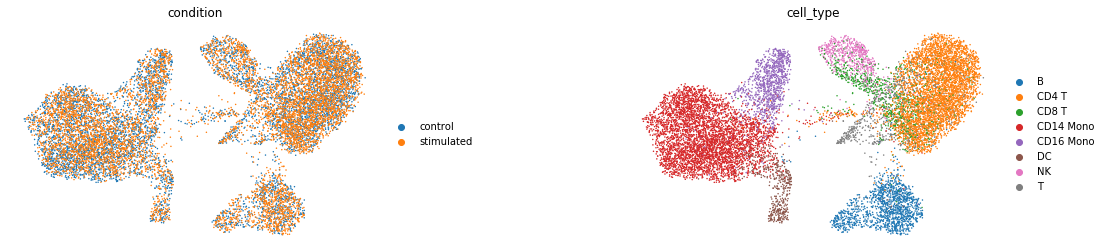

In [10]:
sc.pl.umap(adjusted_adata, color=["condition", "cell_type"], wspace=.5, frameon=False)

## Taking stimulated as reference

In [11]:
adjusted_adata = vsc.translate(model, train_hv, "condition", 'stimulated', dataset["label_encoding"], batch_size=1024)

sc.pp.pca(adjusted_adata)
sc.pp.neighbors(adjusted_adata)
sc.tl.umap(adjusted_adata)

In [13]:
adjusted_adata.write("./fae_naive_16_stim.h5ad")

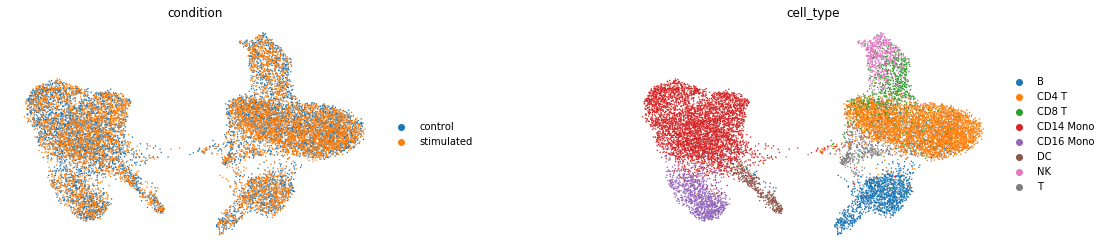

In [12]:
sc.pl.umap(adjusted_adata, color=["condition", "cell_type"], wspace=.5, frameon=False)